In [ ]:
from typing import Dict, List, Optional, Tuple
from IPython.display import clear_output

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid

if torch.cuda.is_available():
    DEVICE = "cuda"
    print('GPU found :)')
else:
    DEVICE = "cpu"
    print('GPU not found :(')

GPU found :)


# Датасет

In [ ]:
IMAGE_DATASETS = ["cifar10"]
TITLE_FONT_SIZE = 16

def prepare_images(train_data: np.ndarray, test_data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    train_data = train_data / 255.0
    test_data = test_data / 255.0

    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    return train_data, test_data


def load_CIFAR10(with_targets: bool = False) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:
    train_dataset = CIFAR10(root="./", train=True, download=True)
    test_dataset = CIFAR10(root="./", train=False, download=True)
    train_data, test_data = train_dataset.data, test_dataset.data

    if with_targets:
        train_labels, test_labels = (
            np.array(train_dataset.targets),
            np.array(test_dataset.targets),
        )
        return train_data, train_labels, test_data, test_labels

    return train_data, None, test_data, None


def load_dataset(
    name: str,
    with_targets: bool = False,
    classes: Optional[List[int]] = None,
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:

    train_data, train_labels, test_data, test_labels = load_CIFAR10(with_targets=with_targets)
    train_data = train_data.astype("float32")
    test_data = test_data.astype("float32")

    if name in IMAGE_DATASETS:
        train_data, test_data = prepare_images(train_data, test_data)

    if classes is not None:
        train_mask = np.isin(train_labels, classes)
        test_mask = np.isin(test_labels, classes)

        train_data = train_data[train_mask]
        test_data = test_data[test_mask]

        if with_targets:
            train_labels = train_labels[train_mask]
            test_labels = test_labels[test_mask]

    if with_targets:
        return train_data, train_labels, test_data, test_labels

    return train_data, test_data


def show_samples(
    samples: np.ndarray | torch.Tensor,
    title: str,
    figsize: Optional[Tuple[int, int]] = None,
    nrow: Optional[int] = None,
) -> None:
    if isinstance(samples, np.ndarray):
        samples = torch.tensor(samples)
    samples = samples.float()
    if (samples > 1).any():
        samples /= 255
    if nrow is None:
        nrow = int(np.sqrt(len(samples)))
    grid_samples = make_grid(samples, nrow=nrow)

    grid_img = grid_samples.permute(1, 2, 0)
    if figsize is None:
        figsize = (6, 6)

    grid_img = grid_img.clip(0, 1)
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.imshow(grid_img)
    plt.axis("off")
    plt.show()


def visualize_images(data: np.ndarray, title: str) -> None:
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = data[idxs]
    show_samples(images, title)

100%|██████████| 170M/170M [00:03<00:00, 48.1MB/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


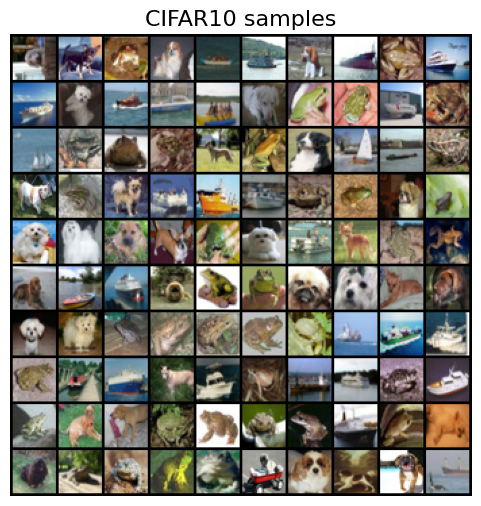

In [ ]:
train_data, train_labels, test_data, test_labels = load_dataset(
    "cifar10",
    with_targets=True,
    classes = [5, 6, 8]
)
visualize_images(train_data, "CIFAR10 samples")

# Модель

In [ ]:
COMMIT_HASH = "9c3ef18c821268297f31d45e36c3b0f2bb538a80"
!if [ -d dgm_utils ]; then rm -Rf dgm_utils; fi
!git clone https://github.com/r-isachenko/dgm_utils.git
%cd dgm_utils
!git checkout {COMMIT_HASH}
!pip install ./
%cd ./..
!rm -Rf dgm_utils

Cloning into 'dgm_utils'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 134 (delta 83), reused 89 (delta 43), pack-reused 0 (from 0)
Receiving objects: 100% (134/134), 26.47 KiB | 564.00 KiB/s, done.
Resolving deltas: 100% (83/83), done.
/content/dgm_utils
Note: switching to '9c3ef18c821268297f31d45e36c3b0f2bb538a80'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 9c3ef18 Return compatibility with Python 

In [ ]:
from dgm_utils import train_model
from dgm_utils import BaseModel

In [ ]:
def get_normal_KL(
    mean_1: torch.Tensor,
    log_std_1: torch.Tensor,
    mean_2: Optional[torch.Tensor] = None,
    log_std_2: Optional[torch.Tensor] = None,
) -> torch.Tensor:
    """
    :Parameters:
    mean_1: means of normal distributions (1)
    log_std_1 : standard deviations of normal distributions (1)
    mean_2: means of normal distributions (2)
    log_std_2 : standard deviations of normal distributions (2)
    :Outputs:
    kl divergence of the normal distributions (1) and normal distributions (2)
    ---
    This function should return the value of KL(p1 || p2),
    where p1 = Normal(mean_1, exp(log_std_1) ** 2), p2 = Normal(mean_2, exp(log_std_2) ** 2).
    If mean_2 and log_std_2 are None values, we will use standard normal distribution.
    Note that we consider the case of diagonal covariance matrix.
    """
    if mean_2 is None:
        mean_2 = torch.zeros_like(mean_1)
    if log_std_2 is None:
        log_std_2 = torch.zeros_like(log_std_1)
    assert mean_1.shape == log_std_1.shape == mean_2.shape == log_std_2.shape

    std_1 = torch.exp(log_std_1)
    std_2 = torch.exp(log_std_2)

    kl_div = 0.5 * (2 * (log_std_2 - log_std_1) + (std_1 ** 2 + (mean_2 - mean_1) ** 2) / std_2 ** 2 - 1)

    return kl_div

def get_normal_nll(
    x: torch.Tensor, mean: torch.Tensor, log_std: torch.Tensor
) -> torch.Tensor:
    """
    This function should return the negative log likelihood log p(x),
    where p(x) = Normal(x | mean, exp(log_std) ** 2).
    Note that we consider the case of diagonal covariance matrix.
    """
    var = torch.exp(log_std) ** 2
    neg_log_likelihood = 0.5 * (torch.log(2 * np.pi * var) + ((x - mean) ** 2) / var)
    return neg_log_likelihood

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, final_relu=True):
        super().__init__()
        self.final_relu = final_relu
        # ====
        # your code
        # here you could try different network structures
        # we suggest to use the following:
        # residual(x) = conv(bn(relu(conv(bn(x)))))
        # output = relu(conv1x1(input) + residual(input))
        # ====
        out_padding = int((kernel_size - 1) / 2)

        if stride == 1:
          padding = int((kernel_size - stride) / 2)
        else:
          padding = int((kernel_size - stride) / 2) + 1

        self.residual = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=out_padding)
        )
        self.skip = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
        )
        self.gelu = nn.GELU()
        if final_relu:
          self.relu2 = nn.ReLU()

    def forward(self, x):
        # ====
        # your code
        # use here defined layers
        result = self.gelu(self.residual(x) + self.skip(x))
        # ====
        if self.final_relu:
            result = self.relu2(result)
        return result


class ResNetTransposeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, final_relu=True):
        super().__init__()
        self.final_relu = final_relu
        # ====
        # your code
        # here you could try different network structures
        # we suggest to use the following:
        # output = conv(bn(f(input))) + f(input), where:
        # f(x) = upconv(bn(x))
        out_padding = kernel_size - 1
        padding = (kernel_size - stride) // 2

        self.f = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        )
        self.conv = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=out_padding, dilation=2)
        )
        # ====
        if self.final_relu:
          self.relu1 = nn.ReLU()

    def forward(self, x):
        # ====
        # your code
        f = self.f(x)
        result = self.conv(f) + f
        # ====
        if self.final_relu:
            result = self.relu1(result)
        return result

In [ ]:
class ConvResNetEncoder(nn.Module):
    def __init__(self, input_shape, n_latent):
        super().__init__()
        self.input_shape = input_shape
        self.n_latent = n_latent
        # ====
        # your code
        # our suggestions:
        # - try to combine multiple resnet blocks
        # - place Flatten + Linear at the end
        self.encoder = self.cnn_layers = nn.Sequential(
            ResNetBlock(input_shape[0], 8, 3, 1, True),
            ResNetBlock(8, 16, 3, 1, True),
            ResNetBlock(16, 64, 5, 2, True),
            ResNetBlock(64, 128, 7, 4, False),
            nn.Flatten(),
            nn.Linear(128 * (input_shape[1] // 8) * (input_shape[2] // 8), 4096),
            nn.ReLU(),
            nn.Linear(4096, n_latent * 2)
        )
        # ====

    def forward(self, x):
        # ====
        # your code
        # apply all blocks defined in init
        # split output tensor to mu and log_std
        output = self.encoder(x)
        mu, log_std = output.chunk(2, dim=1)
        # ====
        return mu, log_std


class ConvResNetDecoder(nn.Module):
    def __init__(self, n_latent, output_shape):
        super().__init__()
        self.n_latent = n_latent
        self.output_shape = output_shape
        # ====
        # your code
        # our suggestions:
        # - apply linear layer to the input
        # - reshape output matrix to 4-dims tensor
        # - try to combine multiple resnet transposed blocks
        self.decoder = nn.Sequential(
            nn.Linear(n_latent, 4096),
            nn.ReLU(),
            nn.Linear(4096, 128 * (output_shape[1] // 8) * (output_shape[2] // 8)),
            nn.ReLU(),
            nn.Unflatten(1, torch.Size((128, output_shape[1] // 8, output_shape[2] // 8))),
            ResNetTransposeBlock(128, 64, 4, 2, final_relu=True),
            ResNetTransposeBlock(64, 16, 4, 2, final_relu=True),
            ResNetTransposeBlock(16, 8, 4, 2, final_relu=True),
            ResNetTransposeBlock(8, self.output_shape[0], 3, 1, final_relu=False)
        )
        # ====

    def forward(self, z):
        # ====
        # your code
        # apply all blocks defined in init
        out = self.decoder(z)
        # ====
        return out

In [ ]:
class ConvResNetVAE(BaseModel):
    def __init__(self, input_shape: tuple, n_latent: int, beta: float = 1) -> None:
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.n_latent = n_latent
        self.beta = beta

        # ====
        # your code
        # define encoder and decoder
        self.encoder = ConvResNetEncoder(input_shape, n_latent)
        self.decoder = ConvResNetDecoder(n_latent, input_shape)
        # ====

    def prior(self, n: int) -> torch.Tensor:
        # ====
        # your code
        # return n samples from prior distribution (we use standart normal for prior)
        z = torch.randn(n, self.n_latent)
        # ====
        z = z.to(self.device)
        return z

    def forward(self, x: torch.Tensor) -> tuple:
        # ====
        # your code
        # 1) apply encoder to get mu_z, log_std_z
        # 2) apply reparametrization trick (use self.prior)
        # 3) apply decoder to get mu_x (which corresponds to reconstructed x)
        mu_z, log_std_z = self.encoder(x)
        z = self.prior(x.shape[0]) * torch.exp(log_std_z) + mu_z
        x_recon = self.decoder(z)
        # ====
        return mu_z, log_std_z, x_recon

    def loss(self, x: torch.Tensor) -> dict:
        # ====
        # your code
        # 1) make forward step to get mu_z, log_std_z, x_recon
        # 2) calculate recon_loss (use get_normal_nll)
        # 3) calcucalte kl_loss (use get_normal_KL)
        mu_z, log_std_z, x_recon = self.forward(x)
        recon_loss = get_normal_nll(x, x_recon, torch.zeros_like(x_recon)).sum(dim=(1,2,3)).mean()
        kl_loss = get_normal_KL(mu_z, log_std_z).sum(dim=1).mean()
        # ====
        return {
            "elbo_loss": recon_loss + self.beta * kl_loss,
            "recon_loss": recon_loss,
            "kl_loss": kl_loss,
        }

    def sample(self, n: int) -> np.ndarray:
        with torch.no_grad():
            # ====
            # your code
            # 1) generate prior samples
            # 2) apply decoder
            sample = self.prior(n)
            x_recon = self.decoder(sample)
            # ====
            samples = torch.clamp(x_recon, -1, 1)
        return samples.cpu().numpy() * 0.5 + 0.5

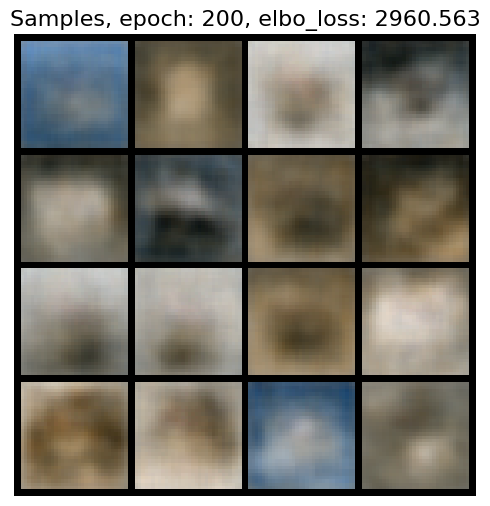

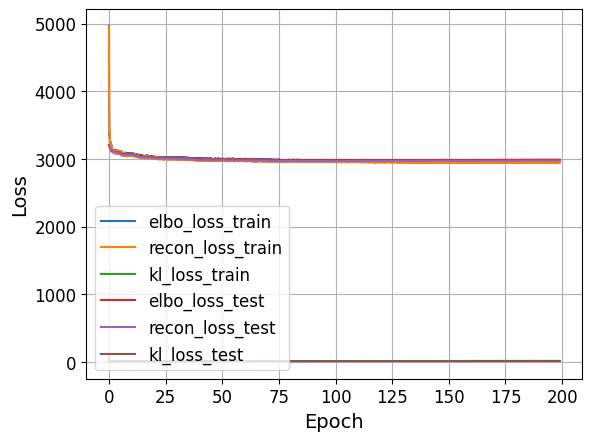

End of the training


In [ ]:
BATCH_SIZE = 256 # any adequate value
EPOCHS = 200  # < 16
LR = 1e-3  # < 1e-3
N_LATENS = 1024  # 128 < _ < 1024
BETA = 1.  # 0.1 < _ < 10
# ====

# we center the data, because it helps the model to fit
centered_train_data = train_data * 2 - 1
centered_test_data = test_data * 2 - 1

train_loader = data.DataLoader(centered_train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(centered_test_data, batch_size=BATCH_SIZE)

model = ConvResNetVAE((3, 32, 32), N_LATENS, BETA)

# ====
# your code
# choose any optimizer/scheduler as you want
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# ====

train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    device=DEVICE,
    n_samples=16,
    visualize_samples=True,
    loss_key="elbo_loss"
)

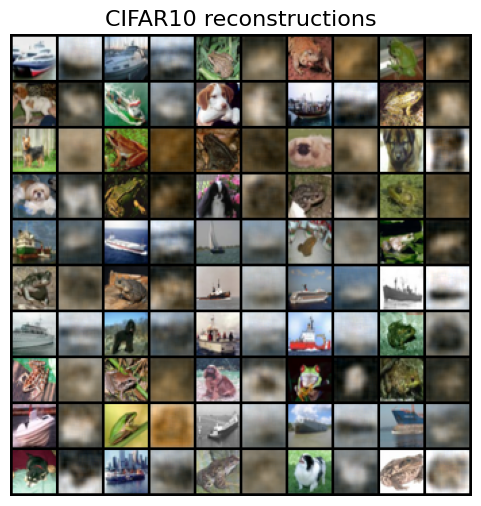

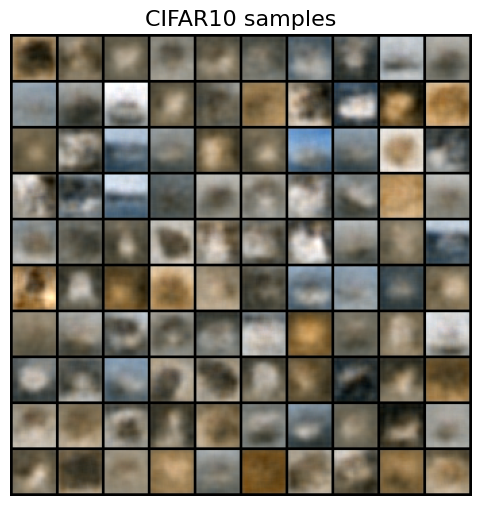

In [ ]:
samples = model.sample(100)

x = next(iter(test_loader))[:50]

x = x.to(model.device)

with torch.no_grad():
    z, _ = model.encoder(x)
    x_recon = torch.clamp(model.decoder(z), -1, 1)
reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
reconstructions = reconstructions.cpu().numpy()

x = next(iter(test_loader))[:20]
x = x.to(model.device)
with torch.no_grad():
    z, _ = model.encoder(x)
    z1, z2 = z.chunk(2, dim=0)
    interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
    interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
    interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
interps = interps.cpu().numpy()

show_samples(reconstructions, 'CIFAR10 reconstructions')
show_samples(samples, 'CIFAR10 samples')

# VAE v.2

In [ ]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class Trim(nn.Module):
    def __init__(self):
        super(Trim, self).__init__()

    def forward(self, x):
        return x[:, :, :32, :32]


class BaseModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError('Not implemented')

    def loss(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        raise NotImplementedError('Not implemented')

    @torch.no_grad()
    def sample(self, n: int) -> np.ndarray:
        raise NotImplementedError('Not implemented')


class ConvEncoder(nn.Module):
    def __init__(self, in_channels=3, n_latent=100):
        super().__init__()
        self.in_channels = in_channels
        self.n_latent = n_latent

        # [(W−K+2P)/S]+1
        self.encoder = nn.Sequential(
            nn.Conv2d(self.in_channels, 32, 3, stride=2, padding=1),
            nn.SiLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.SiLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.Flatten(),
        )

        self.linear_mean = nn.Linear(2048, self.n_latent)
        self.linear_logvar = nn.Linear(2048, self.n_latent)
        # ====

    def forward(self, x):
        x = self.encoder(x)
        mean = self.linear_mean(x)
        var = self.linear_logvar(x)
        return mean, var


class ConvDecoder(nn.Module):
    def __init__(self, n_latent=100, out_channels=3):
        super().__init__()
        self.n_latent = n_latent
        self.out_channels = out_channels

        self.linear = nn.Linear(self.n_latent, 2048)
        self.reshape = Reshape(-1, 128, 4, 4)

        # [(W - 1) * S - 2P + D * (K - 1) + 1]
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=0),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1),
            nn.ConvTranspose2d(32, self.out_channels, 3, stride=2, padding=1),
        )
        self.trim = Trim()

    def forward(self, z):
        z = self.linear(z)
        z = self.reshape(z)
        z = self.decoder(z)
        z = self.trim(z)
        z = F.sigmoid(z)
        return z


class ConvVAE(BaseModel):
    def __init__(self, input_shape: tuple, n_latent: int, beta: float = 1) -> None:
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.n_latent = n_latent
        self.beta = beta

        self.encoder = ConvEncoder(input_shape[0], n_latent)
        self.decoder = ConvDecoder(n_latent, input_shape[0])

    def prior(self, n: int) -> torch.Tensor:
        z = torch.randn(n, self.n_latent)
        z = z.to(self.device)
        return z

    def forward(self, x: torch.Tensor) -> tuple:
        mu_z, log_std_z = self.encoder(x)
        std_z = torch.exp(log_std_z)
        z = self.prior(x.shape[0]) * std_z + mu_z
        x_recon = self.decoder(z)
        return mu_z, log_std_z, x_recon

    def loss(self, x: torch.Tensor) -> dict:
        mu_z, log_std_z, x_recon = self.forward(x)
        recon_loss = get_normal_nll(x, x_recon, torch.zeros_like(x_recon)).mean()
        kl_loss = get_normal_KL(mu_z, log_std_z).mean()

        return {
            "elbo_loss": recon_loss + self.beta * kl_loss,
            "recon_loss": recon_loss,
            "kl_loss": kl_loss,
        }

    def sample(self, n: int) -> np.ndarray:
        with torch.no_grad():
            z = self.prior(n)
            x_recon = self.decoder(z)
            samples = torch.clamp(x_recon, -1, 1)
        return samples.cpu().numpy() * 0.5 + 0.5

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # [(W−K+2P)/S]+1
        self.conv1 = nn.Conv2d(3, 32, 3, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride = 2, padding = 1)
        self.flatten = nn.Flatten()

        self.linear_mean = nn.Linear(2048, 100)
        self.linear_logvar = nn.Linear(2048, 100)

        # [(W - 1) * S - 2P + D * (K - 1) + 1]
        self.linear = nn.Linear(100, 2048)
        self.reshape = Reshape(-1, 128, 4, 4)
        self.deconv1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=0)
        self.deconv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1)
        self.trim = Trim()

    def reparameterized(self, mean, var):
        eps = torch.randn(mean.size(0), mean.size(1)).to(DEVICE)
        z = mean + eps * torch.exp(var / 2.)
        return z

    def encode(self, x): # Using silu instead of relu here
        x = F.silu(self.conv1(x))
        x = F.silu(self.conv2(x))
        x = self.conv3(x)
        x = self.flatten(x)
        mean = self.linear_mean(x)
        var = self.linear_logvar(x)
        z = self.reparameterized(mean, var)
        return mean, var, z

    def decode(self, z):
        z = self.linear(z)
        z = self.reshape(z)
        z = F.silu(self.deconv1(z))
        z = F.silu(self.deconv2(z))
        z = F.silu(self.deconv3(z))
        z = self.trim(z)
        z = F.sigmoid(z)
        return z

    def forward(self, x):
        mean, var, z = self.encode(x)
        z = self.decode(z)
        return mean, var, z

In [ ]:
def get_normal_nll(
    x: torch.Tensor, mean: torch.Tensor, log_std: torch.Tensor
) -> torch.Tensor:
    """
    This function should return the negative log likelihood log p(x),
    where p(x) = Normal(x | mean, exp(log_std) ** 2).
    Note that we consider the case of diagonal covariance matrix.
    """
    var = torch.exp(log_std) ** 2
    neg_log_likelihood = 0.5 * (torch.log(2 * np.pi * var) + ((x - mean) ** 2) / var)
    return neg_log_likelihood

In [ ]:
device = DEVICE
train_data, test_data = load_dataset("cifar10")

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
random_seed = 42
learning_rate = 0.001
batch_size = 32
epochs = 50
KL_weight = 0.000075 # The KL divergence is much larger than MAE loss, scaling it down

# centered_train_data = train_data * 2 - 1
image_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = ConvVAE(input_shape=(3, 32, 32), n_latent=100).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

train_losses_total, train_losses_total_avg = [], []
train_losses_reconstruction, train_losses_reconstruction_avg = [], []
train_losses_KL, train_losses_KL_avg = [], []
for epoch in range(epochs):
    train_loss_total = 0.0
    train_loss_reconstruction = 0.0
    train_loss_KL = 0.0
    for images in tqdm(image_loader):
        images = images.to(device)
        mean, var, outputs = model(images)

        optimizer.zero_grad()
        loss1 = criterion(outputs, images)
        loss2 = torch.mean(-0.5 * torch.sum(1 + var - mean**2 - torch.exp(var),axis=1),axis=0) # sum over latent dimension, not batch
        # -0.5 * torch.sum(1 + var - mean**2 - torch.exp(var), axis = 1).mean()
        # loss2 = torch.atan(loss2) / (np.pi / 2) # scaling it to [0,1]
        loss = loss1  + KL_weight * loss2
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            train_losses_reconstruction.append(loss1.item())
            train_losses_KL.append(loss2.item())
            train_losses_total.append(loss.item())
            train_loss_reconstruction += loss1.item() * images.size(0)
            train_loss_KL += loss2.item() * images.size(0)
            train_loss_total += loss.item() * images.size(0)

    train_loss_total /= len(image_loader)
    train_loss_reconstruction /= len(image_loader)
    train_loss_KL /= len(image_loader)

    train_losses_total_avg.append(train_loss_total)
    train_losses_reconstruction_avg.append(train_loss_reconstruction)
    train_losses_KL_avg.append(train_loss_KL)

    clear_output(wait=True)
    print('-----------------------------------------------------')
    print(f'Epoch{epoch + 1}')
    print(f'Total loss = {train_loss_total:.3f}')
    print(f'Reconstruction loss = {train_loss_reconstruction:.3f}, KL = {train_loss_KL:.3f}')

-----------------------------------------------------
Epoch50
Total loss = 0.387
Reconstruction loss = 0.246, KL = 1880.639


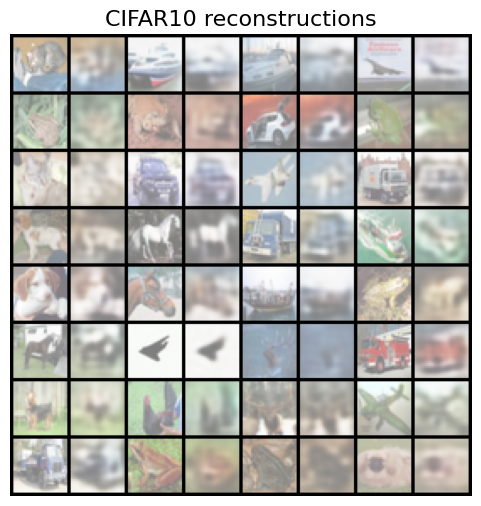

In [ ]:
x = next(iter(test_loader))[:50]

x = x.to(DEVICE)

with torch.no_grad():
    z, _ = model.encoder(x)
    x_recon = torch.clamp(model.decoder(z), -1, 1)
    # _, _, new_fig = model(x.to(DEVICE))
reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
reconstructions = reconstructions.cpu().numpy()

show_samples(reconstructions, 'CIFAR10 reconstructions')

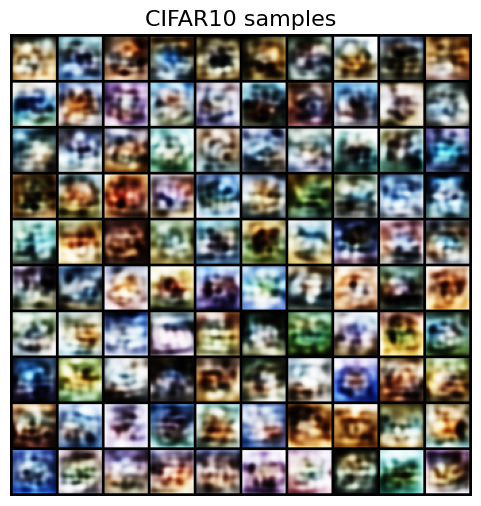

In [ ]:
samples = 2 * (model.sample(100) - 0.5)
# samples = model.sample(100)
show_samples(samples, 'CIFAR10 samples')

# Эмбеддинг для модели

In [ ]:
class VAEVectorizer:
    def __init__(self, vae_model, fixed_noise_vectors=None, fixed_model=None):
        self.vae_model = vae_model
        self.fixed_noise_vectors = fixed_noise_vectors
        self.fixed_model = fixed_model

    def dummy_vectorize(self):
        # Метод 1: Вытягивает в вектор все веса модели по фиксированному порядку
        weights = []
        for param in self.vae_model.parameters():
            weights.append(param.data.view(-1))
        return torch.cat(weights)

    def random_noise_vectorize(self):
        # Метод 2: Кодирует модель как вектор эмбеддингов, полученных при передаче фиксированных векторов случайного шума
        embeddings = []
        for noise in self.fixed_noise_vectors:
            with torch.no_grad():
                z = noise.unsqueeze(0)  # Добавляем размерность батча
                decoded = self.vae_model.decode(z)
                embeddings.append(decoded.view(-1))
        return torch.cat(embeddings)

    def encoder_vectorize(self):
        # Метод 3: Кодирует модель с помощью другой фиксированной модели
        with torch.no_grad():
            encoded = self.fixed_model(self.vae_model)
        return encoded.view(-1)

In [ ]:
dummy_vec = VAEVectorizer(model).dummy_vectorize()

In [ ]:
dummy_vec

tensor([ 0.0654, -0.0311,  0.0738,  ..., -0.1850, -0.1762, -0.4221],
       device='cuda:0')

# 3 самых далёких класса в CIFAR10

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

model = models.resnet18(pretrained=True)
model.fc = torch.nn.Identity()  # Удаляем последний слой классификации
model.eval()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=False)

features = []
labels = []
with torch.no_grad():
    for images, label in train_loader:
        features.append(model(images).numpy())
        labels.append(label.numpy())

features = np.vstack(features)
labels = np.hstack(labels)

# Вычисление центроидов и расстояний между ними
centroids = np.array([features[labels == i].mean(axis=0) for i in range(10)])
distances = euclidean_distances(centroids)

max_distance = 0
max_classes = (0, 1, 2)
for i in range(10):
    for j in range(i + 1, 10):
        for k in range(j + 1, 10):
            dist = distances[i, j] + distances[j, k] + distances[k, i]
            if dist > max_distance:
                max_distance = dist
                max_classes = (i, j, k)

print(f"Три самых непохожих класса: {max_classes}")